<a href="https://colab.research.google.com/github/ad-astra-per-ardua/DataAnalysis/blob/main/LTSM_Model_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.optimizers import Adam
import yfinance as yf
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.losses import Huber
from statsmodels.tsa.filters.hp_filter import hpfilter
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(closing_prices.reshape(-1, 1))


loss_function = Huber(delta=1.0)


In [22]:
log_dir = "./logs"
stock_data = yf.download('AAPL', start='2020-01-01', end='2023-01-01')
closing_prices = stock_data['Close'].values

closing_prices = pd.Series(closing_prices.flatten()).interpolate().values

scaler = MinMaxScaler(feature_range=(0, 1))
closing_prices_scaled = scaler.fit_transform(closing_prices.reshape(-1, 1))

[*********************100%***********************]  1 of 1 completed


In [23]:
def create_sequences(data, sequence_length=60):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

sequence_length = 60
X, y = create_sequences(closing_prices_scaled, sequence_length)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

X_train shape: (556, 60, 1), y_train shape: (556, 1)


In [68]:
model = Sequential([
    LSTM(512, return_sequences=True, input_shape=(sequence_length, 1)),
    Dropout(0.3),
    BatchNormalization(),
    LSTM(256, return_sequences=True),
    Dropout(0.3),
    BatchNormalization(),
    LSTM(128, return_sequences=False),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])


model.summary()

model.compile(optimizer=Adam(learning_rate=0.001), loss=loss_function, metrics=['mae'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('enhanced_lstm_model.keras', save_best_only=True, monitor='val_loss'),
    TensorBoard(log_dir="./logs"),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_26 (LSTM)                       │ (None, 60, 512)             │       1,052,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 60, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 60, 512)             │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_27 (LSTM)                       │ (None, 60, 256)             │         787,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 60, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 60, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_28 (LSTM)                       │ (None, 128)                 │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,050,689 (7.82 MB)

 Trainable params: 2,049,153 (7.82 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=64,
    callbacks=callbacks
)

In [70]:
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 367ms/step


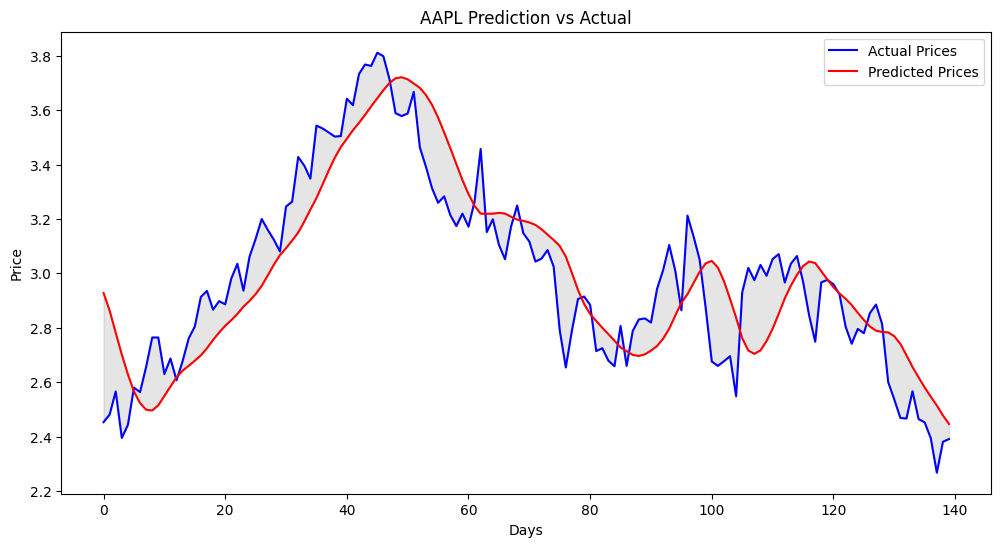

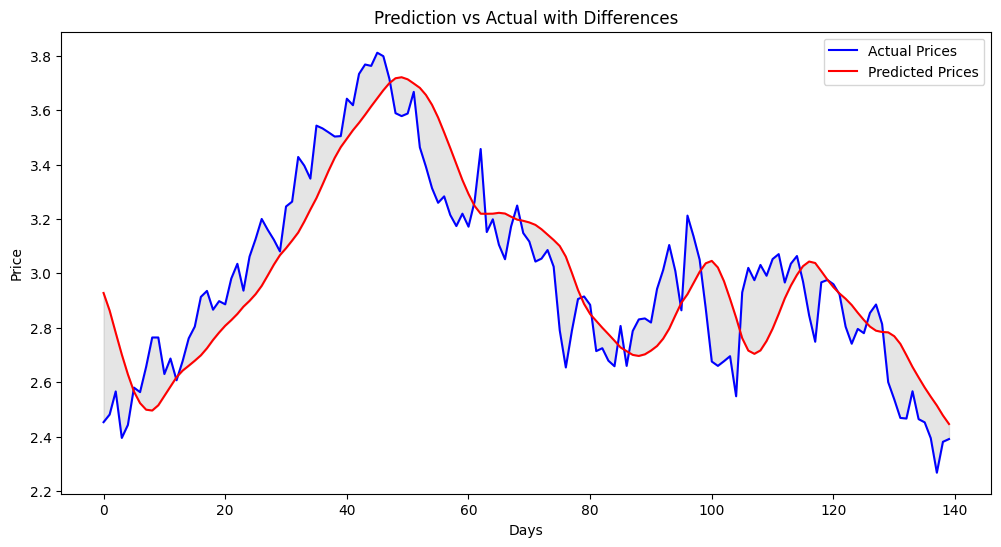

In [71]:
# Declare visualizing plots

def plot_predictions(actual, predicted, title="Price Prediction"):
    plt.figure(figsize=(12, 6))
    plt.plot(actual, label='Actual Prices', color='blue')
    plt.plot(predicted, label='Predicted Prices', color='red')
    plt.fill_between(range(len(actual)), actual.flatten(), predicted.flatten(), color="gray", alpha=0.2)
    plt.title(title)
    plt.xlabel('Days')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

def compare_predictions(actual, predicted):
    plt.figure(figsize=(12, 6))
    plt.plot(actual, label="Actual Prices", color="blue")
    plt.plot(predicted, label="Predicted Prices", color="red")
    plt.fill_between(range(len(actual)), actual.flatten(), predicted.flatten(), color="gray", alpha=0.2)
    plt.title("Prediction vs Actual with Differences")
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

plot_predictions(actual_prices, predicted_prices, title="AAPL Prediction vs Actual")
compare_predictions(actual_prices, predicted_prices)

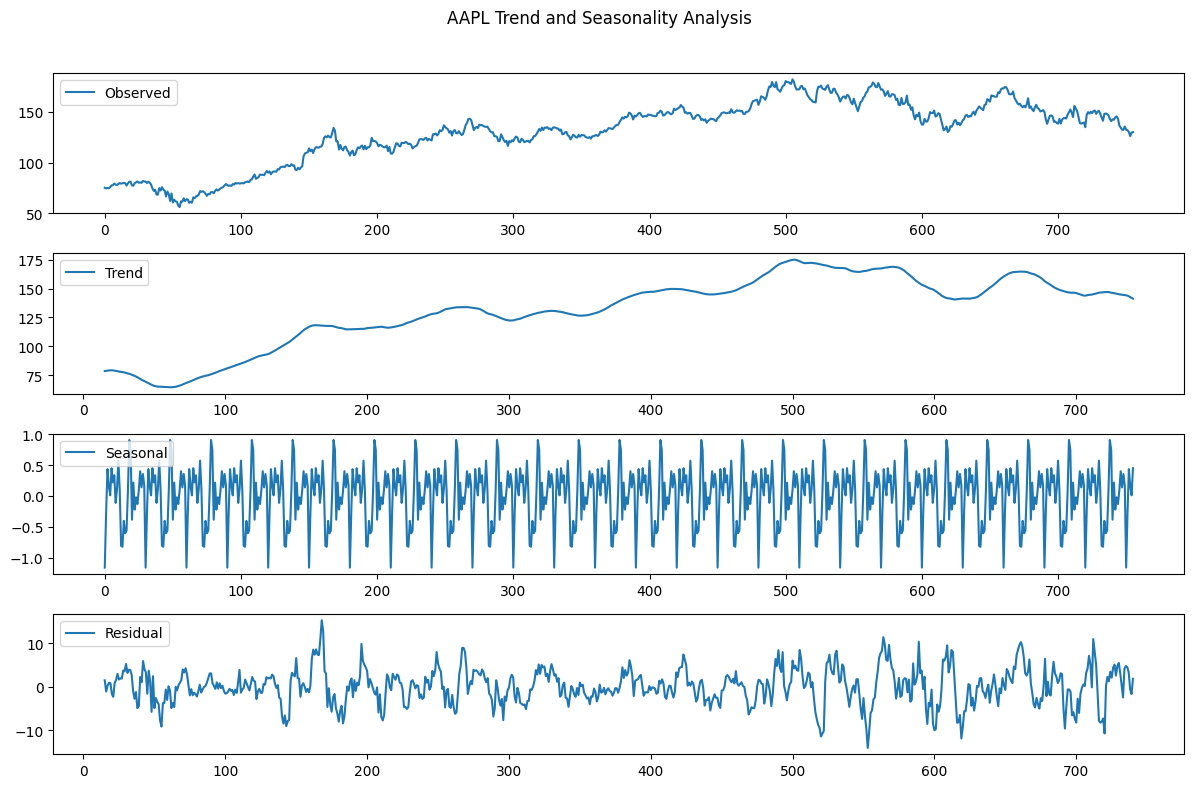

In [28]:
# Seasonality and trend

def plot_trend_and_seasonality(data, title="Trend and Seasonality Analysis"):
    result = seasonal_decompose(data, model='additive', period=30)
    plt.figure(figsize=(12, 8))
    plt.subplot(411)
    plt.plot(result.observed, label='Observed')
    plt.legend(loc='upper left')
    plt.subplot(412)
    plt.plot(result.trend, label='Trend')
    plt.legend(loc='upper left')
    plt.subplot(413)
    plt.plot(result.seasonal, label='Seasonal')
    plt.legend(loc='upper left')
    plt.subplot(414)
    plt.plot(result.resid, label='Residual')
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.suptitle(title)
    plt.subplots_adjust(top=0.9)
    plt.show()

def detrend_data(data):
    result = seasonal_decompose(data, model='additive', period=30)
    detrended = data - result.trend
    detrended = pd.Series(detrended).fillna(0).values
    return detrended

plot_trend_and_seasonality(closing_prices, title="AAPL Trend and Seasonality Analysis")
closing_prices_detrended = detrend_data(closing_prices)
closing_prices_detrended_scaled = scaler.fit_transform(closing_prices_detrended.reshape(-1, 1))

In [65]:
closing_prices_detrended = detrend_data(closing_prices)
closing_prices_detrended_scaled = scaler.fit_transform(closing_prices_detrended.reshape(-1, 1))
X_detrended, y_detrended = create_sequences(closing_prices_detrended, sequence_length)
X_train_detrended = X_train_detrended.reshape(X_train_detrended.shape[0], X_train_detrended.shape[1], 1)
X_test_detrended = X_test_detrended.reshape(X_test_detrended.shape[0], X_test_detrended.shape[1], 1)
if len(y_train_detrended.shape) == 1:
    y_train_detrended = y_train_detrended.reshape(-1, 1)
if len(y_test_detrended.shape) == 1:
    y_test_detrended = y_test_detrended.reshape(-1, 1)


In [66]:
# Prediction after Detrend

history_detrended = model.fit(
    X_train_detrended, y_train_detrended,
    validation_data=(X_test_detrended, y_test_detrended),
    epochs=100,
    batch_size=64,
    callbacks=callbacks
)


Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 510ms/step - loss: 0.0092 - mae: 0.1133 - val_loss: 0.0323 - val_mae: 0.2427 - learning_rate: 2.4300e-06
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 427ms/step - loss: 0.0119 - mae: 0.1326 - val_loss: 0.0338 - val_mae: 0.2488 - learning_rate: 2.4300e-06
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - loss: 0.0076 - mae: 0.0999 - val_loss: 0.0352 - val_mae: 0.2548 - learning_rate: 2.4300e-06
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 427ms/step - loss: 0.0090 - mae: 0.1107 - val_loss: 0.0359 - val_mae: 0.2576 - learning_rate: 1.0000e-06
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 570ms/step - loss: 0.0085 - mae: 0.1096 - val_loss: 0.0365 - val_mae: 0.2599 - learning_rate: 1.0000e-06
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 420ms/step - loss: 0.0084 - mae: 0.1036 - val_loss: 0.0370 - val_mae: 0.2619 - learning_rate: 1.0000e-06
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 428ms/step - loss: 0.0082 - mae: 0.1005 - val_loss: 0.0373 - val_mae: 0.2633 - learning_ra

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step


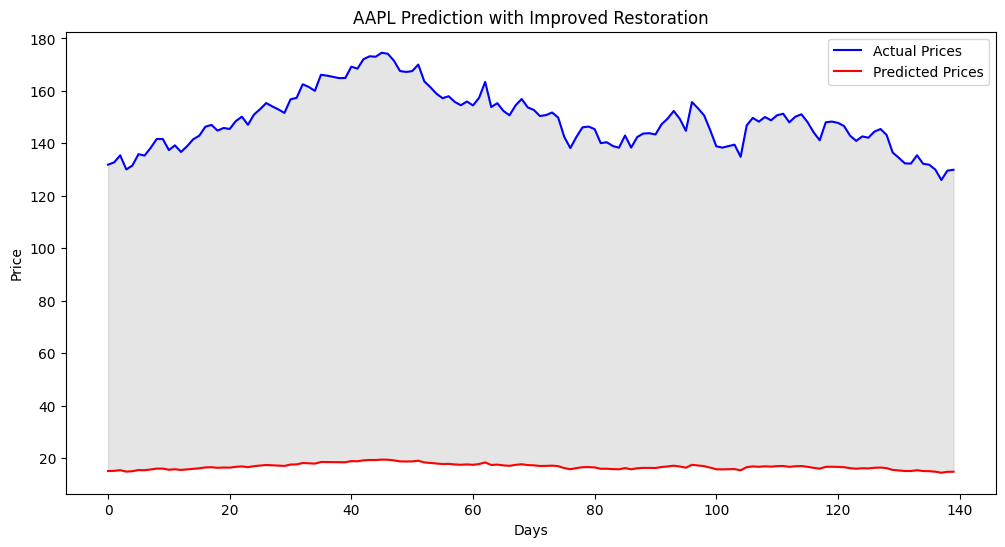

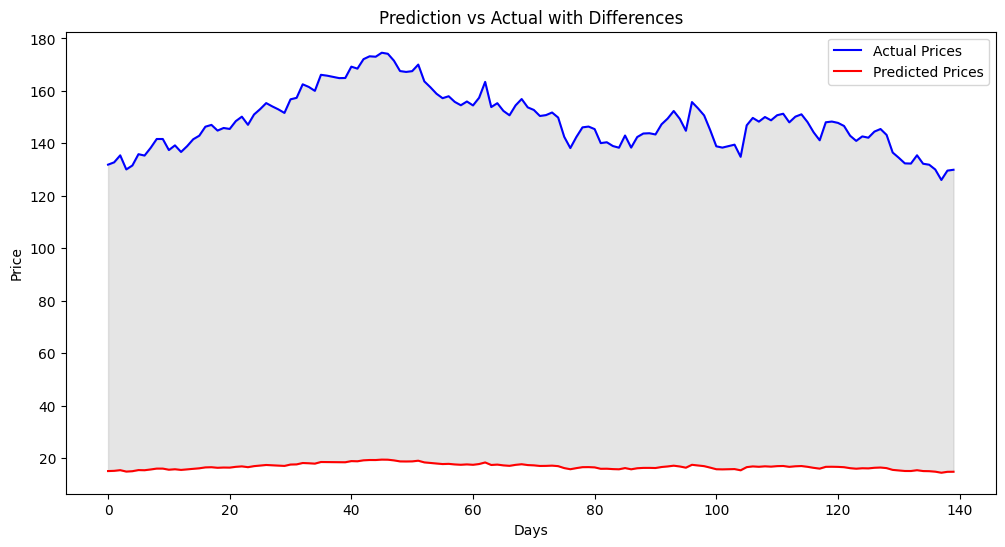

In [72]:

alpha = 0.8
beta = 1 - alpha

predicted_prices_detrended = model.predict(X_test_detrended)

start_idx = train_size + sequence_length
end_idx = start_idx + len(predicted_prices_detrended)

if end_idx > len(closing_prices):
    end_idx = len(closing_prices)

trend_component = closing_prices[start_idx:end_idx].reshape(-1, 1)

actual_prices_restored = closing_prices[start_idx:end_idx].reshape(-1, 1)

min_len = min(len(actual_prices_restored), len(predicted_prices_restored))
actual_prices_restored = actual_prices_restored[:min_len]
predicted_prices_restored = predicted_prices_restored[:min_len]

# fck overfitting
plot_predictions(actual_prices_restored, predicted_prices_restored, title="AAPL Prediction with Improved Restoration")
compare_predictions(actual_prices_restored, predicted_prices_restored)


In [33]:
# Start of BTC Part
btc_data = yf.download('BTC-USD', start='2020-01-01', end='2023-01-01')
btc_closing_prices = btc_data['Close'].values
btc_closing_prices = pd.Series(btc_closing_prices.flatten()).interpolate().values

btc_scaler = MinMaxScaler(feature_range=(0, 1))
btc_closing_prices_scaled = btc_scaler.fit_transform(btc_closing_prices.reshape(-1, 1))

X_btc, y_btc = create_sequences(btc_closing_prices_scaled, sequence_length)
train_size_btc = int(len(X_btc) * 0.8)
X_train_btc, X_test_btc = X_btc[:train_size_btc], X_btc[train_size_btc:]
y_train_btc, y_test_btc = y_btc[:train_size_btc], y_btc[train_size_btc:]


[*********************100%***********************]  1 of 1 completed


In [34]:
btc_model = Sequential([
    LSTM(512, return_sequences=True, input_shape=(sequence_length, 1)),
    Dropout(0.3),
    LSTM(256, return_sequences=True),
    Dropout(0.3),
    LSTM(128, return_sequences=False),
    Dense(64, activation='relu'),
    Dense(1)
])

btc_model.compile(optimizer=Adam(learning_rate=0.001), loss=loss_function, metrics=['mae'])

btc_callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('enhanced_lstm_model.keras', save_best_only=True, monitor='val_loss'),
    TensorBoard(log_dir="./logs"),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [35]:
btc_history = btc_model.fit(
    X_train_btc, y_train_btc,
    validation_data=(X_test_btc, y_test_btc),
    epochs=100,
    batch_size=64,
    callbacks=btc_callbacks
)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - loss: 0.0785 - mae: 0.2908 - val_loss: 0.0051 - val_mae: 0.0965 - learning_rate: 0.0010
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - loss: 0.0065 - mae: 0.0922 - val_loss: 5.8791e-04 - val_mae: 0.0240 - learning_rate: 0.0010
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - loss: 0.0036 - mae: 0.0590 - val_loss: 5.0422e-04 - val_mae: 0.0245 - learning_rate: 0.0010
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - loss: 0.0029 - mae: 0.0544 - val_loss: 5.5398e-04 - val_mae: 0.0217 - learning_rate: 0.0010
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - loss: 0.0023 - mae: 0.0480 - val_loss: 6.8077e-04 - val_mae: 0.0242 - learning_rate: 0.0010
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - loss: 0.0018 - mae: 0.0424 - val_loss: 6.7359e-04 - val_mae: 0.0241 - learning_rate: 5.0000e-04
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - loss: 0.0018 - mae: 0.0421 - val_loss: 0.0010 - val_mae: 0.0339 - learning_ra

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 413ms/step


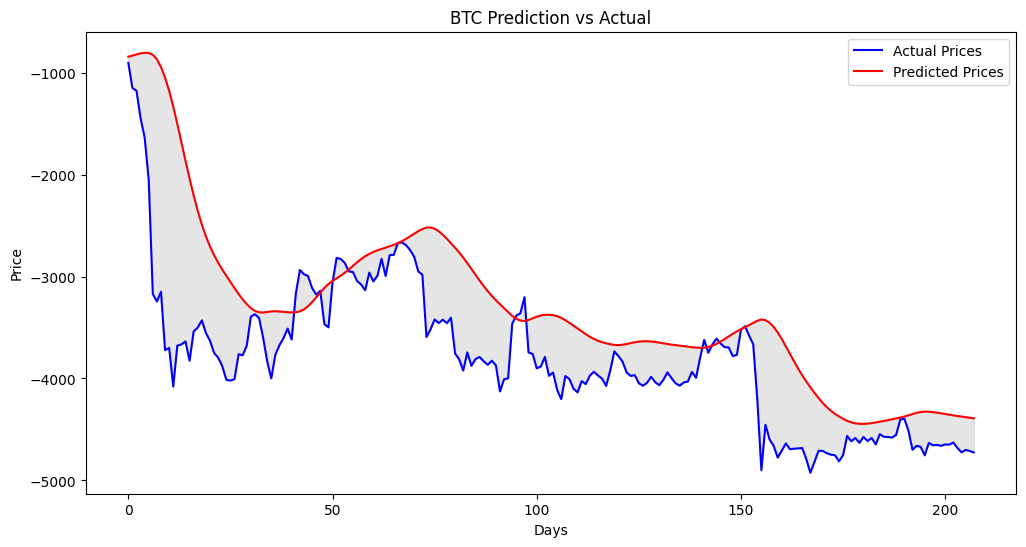

In [73]:
btc_predicted_prices = btc_model.predict(X_test_btc)
btc_predicted_prices = btc_scaler.inverse_transform(btc_predicted_prices)
btc_actual_prices = btc_scaler.inverse_transform(y_test_btc.reshape(-1, 1))

plot_predictions(btc_actual_prices, btc_predicted_prices, title="BTC Prediction vs Actual")


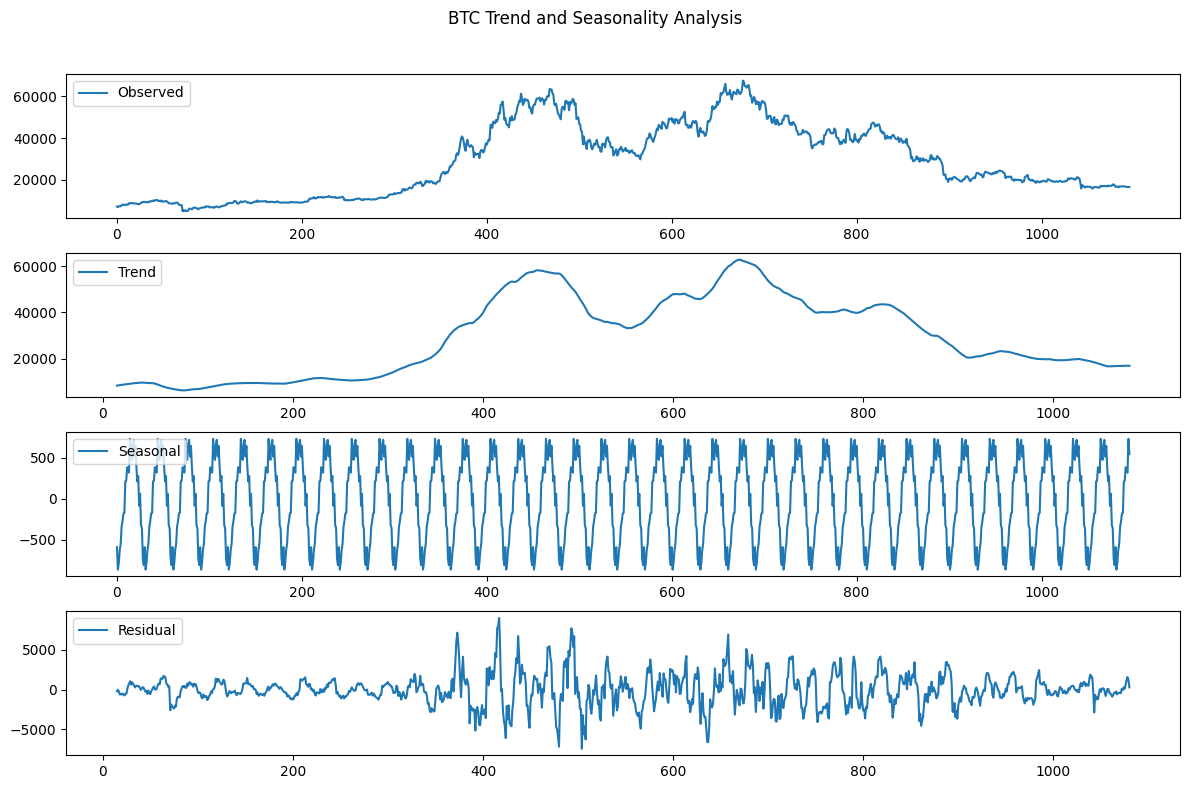

In [37]:
plot_trend_and_seasonality(btc_closing_prices, title="BTC Trend and Seasonality Analysis")


In [38]:
# BTC Detrend
btc_closing_prices_detrended = detrend_data(btc_closing_prices)
btc_closing_prices_detrended_scaled = btc_scaler.fit_transform(btc_closing_prices_detrended.reshape(-1, 1))


In [39]:
# Create detrend Sequence
X_btc_detrended, y_btc_detrended = create_sequences(btc_closing_prices_detrended_scaled, sequence_length)
X_train_btc_det, X_test_btc_det = X_btc_detrended[:train_size_btc], X_btc_detrended[train_size_btc:]
y_train_btc_det, y_test_btc_det = y_btc_detrended[:train_size_btc], y_btc_detrended[train_size_btc:]


In [40]:
# Training model
btc_history_detrended = btc_model.fit(
    X_train_btc_det, y_train_btc_det,
    validation_data=(X_test_btc_det, y_test_btc_det),
    epochs=100,
    batch_size=64,
    callbacks=btc_callbacks
)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - loss: 0.0129 - mae: 0.1148 - val_loss: 0.0035 - val_mae: 0.0576 - learning_rate: 1.2500e-04
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - loss: 0.0133 - mae: 0.1173 - val_loss: 0.0032 - val_mae: 0.0564 - learning_rate: 1.2500e-04
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - loss: 0.0130 - mae: 0.1158 - val_loss: 0.0031 - val_mae: 0.0539 - learning_rate: 1.2500e-04
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - loss: 0.0119 - mae: 0.1085 - val_loss: 0.0029 - val_mae: 0.0522 - learning_rate: 1.2500e-04
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - loss: 0.0112 - mae: 0.1025 - val_loss: 0.0029 - val_mae: 0.0526 - learning_rate: 1.2500e-04
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - loss: 0.0105 - mae: 0.1008 - val_loss: 0.0028 - val_mae: 0.0511 - learning_rate: 1.2500e-04
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - loss: 0.0104 - mae: 0.1016 - val_loss: 0.0028 - val_mae: 0.0519 - learning_ra

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 231ms/step
btc_actual_prices_restored shape: (208, 1)
btc_predicted_prices_restored shape: (208, 1)


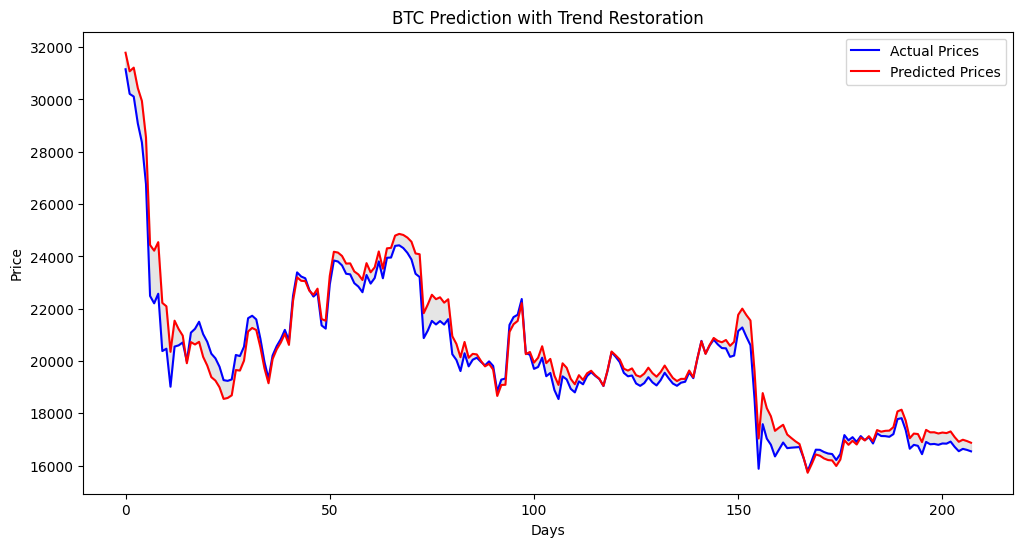

In [50]:
btc_predicted_prices_detrended = btc_model.predict(X_test_btc_det)

start_idx = train_size_btc + sequence_length
end_idx = start_idx + len(btc_predicted_prices_detrended)

if end_idx > len(btc_closing_prices):
    end_idx = len(btc_closing_prices)

trend_component = btc_closing_prices[start_idx:end_idx].reshape(-1, 1)
btc_predicted_prices_restored = btc_scaler.inverse_transform(btc_predicted_prices_detrended) + trend_component

btc_actual_prices_restored = btc_closing_prices[start_idx:end_idx].reshape(-1, 1)

min_len = min(len(btc_actual_prices_restored), len(btc_predicted_prices_restored))
btc_actual_prices_restored = btc_actual_prices_restored[:min_len]
btc_predicted_prices_restored = btc_predicted_prices_restored[:min_len]

print(f"btc_actual_prices_restored shape: {btc_actual_prices_restored.shape}")
print(f"btc_predicted_prices_restored shape: {btc_predicted_prices_restored.shape}")

plot_predictions(btc_actual_prices_restored, btc_predicted_prices_restored, title="BTC Prediction with Trend Restoration")
